# **Modelo de regresión lineal**

## **Fuentes de datos utilizadas**

Para el desarrollo del modelo se utilizaron 4 fuentes de datos, la principal el dataset resultante **muelle.parquet** generado en el notebook **3_Union_datos_operativos_y_comerciales**. Este dataset combina los datos del área operativa con los del área comercial.

Adicionalmente se utilizan 3 dataset complementarios para enriquecer el dataset principal que información que puede ayudar al modelo.

- **Aeropuertos**: En el cual se encuentran los IATA CODE, de la gran mayoria de ciudades del mundo, con los correspondientes paises.
- **pib**: Este dataset contiene información del PIB del año 2021 de la gran mayoria de paises.
- **hdi**: Este dataset contiene información del Índice de Desarrollo Humano del año 2021, que es una métrica recopilada por el Programa de las Naciones Unidas para el Desarrollo y utilizada para cuantificar el "logro medio de un país en tres dimensiones básicas del desarrollo humano: una vida larga y saludable, el conocimiento y un nivel de vida digno". de la gran mayoria de paises.

### **Diccionarios de datos**

| Campo                 | Descripción                                                                             |
|:----------------------|:----------------------------------------------------------------------------------------|
| IATA CODE             |  Código de aeropuertos de IATA (International Air Transport Association airport code).  |
| Destino               | Ciudad de destino del vuelo.                                                            |
| Tipo de vuelo         | Define si el vuelo es doméstico o internacional.                                        |
| Sala                  | Sala de embarque.                                                                       |
| Muelle                | Espigón del aeropuerto (Internacional, muelle sur o muelle norte).                      |
| AEROLÍNEA             | Nombre de la aerolínea.                                                                 |
| Tipo aerolínea        | Carga o Comercial.                                                                      |
| STD                   | Hora de salida programada.                                                              |
| Hora entera           | Hora de salida del vuelo.                                                               |
| FECHA DIA             | Día del vuelo.                                                                          |
| Pasajeros saliendo    | Número de pasajeros en la aeronave.                                                     |
| Semana                | Semana del año del vuelo.                                                               |
| Mes                   | Mes del vuelo.                                                                          |
| Día                   | Día del vuelo.                                                                          |
| Año                   | Año del vuelo.                                                                          |
| Pasajeros por Muelle y Hora | Número de pasajeros por Muelle, FECHA DIA y Hora entera                                                                      |
| Porcentaje pasajeros vuelo | Radio entre  Pasajeros saliendo y  Pasajeros por Muelle y Hora                                                                      |
| valor_venta           | Ventas generadas en el muelle del vuelo en las dos horas anteriores a este.                                                                             |
| Parte de valor_venta  | Multiplicacion entre Porcentaje pasajeros vuelo y valor_venta para obtener las ventas generadas por el vuelo. Esta es la variable de salida, pero dado que su valor es altamente correlacionado a valor_venta, se puede utilizar valor_venta como reemplazo.                                                                             |

### **Obtener los datos**

**Importar las librerías requeridas**

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Data management Libraries
import pandas as pd
import numpy as np

# Data visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import utils_functions as utils

# Aditional libraries
import pylev
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, pointbiserialr

# Model libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
import statsmodels.api as sm

**Lectura de los datos**

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [3]:
# create the dataFrame 
dataframe = pd.read_parquet('data/muelle.parquet')

In [4]:
dataframe

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50770,YYZ,toronto,internacional,a9b,muelle internacional oriente,avianca s a,legacy,2022-09-21 14:50:00,14,miercoles,93.0,38,9,21,2022,93.0,1.0,656639977.6,656639977.6
50771,YYZ,toronto,internacional,a9b,muelle internacional oriente,avianca s a,legacy,2022-09-26 14:50:00,14,lunes,94.0,39,9,26,2022,94.0,1.0,768444414.0,768444414.0
50772,YYZ,toronto,internacional,a9b,muelle internacional oriente,avianca s a,legacy,2022-09-29 14:50:00,14,jueves,97.0,39,9,29,2022,97.0,1.0,847381148.7,847381148.7
50773,YYZ,toronto,internacional,a9b,muelle internacional oriente,avianca s a,legacy,2022-10-11 14:50:00,15,martes,98.0,41,10,11,2022,98.0,1.0,745755299.6,745755299.6


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50775 entries, 0 to 50774
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IATA CODE                    50775 non-null  object        
 1   Destino                      50775 non-null  object        
 2   Tipo de vuelo                50775 non-null  object        
 3   Sala                         50775 non-null  object        
 4   Muelle                       50775 non-null  object        
 5   AEROLÍNEA                    50775 non-null  object        
 6   Tipo aerolínea               50775 non-null  object        
 7   STD                          50775 non-null  datetime64[ns]
 8   Hora entera                  50775 non-null  int64         
 9   FECHA DIA                    50775 non-null  object        
 10  Pasajeros saliendo           50775 non-null  float64       
 11  Semana                       50775 non-nu

## **Análisis y preparación de los datos**

### **Variable IATA CODE**

Esta variable se refiere a un código único de identificación para cada aeropuerto en todo el mundo. La estamos utilizando para identificar el destino de los vuelos en nuestro conjunto de datos. Se ha seleccionado esta variable debido a su capacidad para garantizar la singularidad de los valores. Además, a través de este código, podemos determinar otros atributos como el país de destino y el continente. Dado su alto número de categorías únicas, no podemos emplear esta variable directamente en el modelo de regresión. Si intentamos aplicar alguna técnica de codificación, resultaría en la generación de numerosas variables dummy. Por lo tanto, utilizaremos esta variable para agregar los atributos de **País Destino** y **Continente Destino** a nuestro conjunto de datos.

In [6]:
dataframe['IATA CODE'].unique()

array(['AEP', 'AMS', 'ASU', 'ATL', 'AUA', 'AZA', 'BCN', 'BGI', 'BLB',
       'BOS', 'CBB', 'CCS', 'CDG', 'CNF', 'CUN', 'CUR', 'DFW', 'EWR',
       'EZE', 'FLL', 'FRA', 'GDL', 'GIG', 'GRU', 'GUA', 'GYE', 'HAV',
       'HRL', 'IAD', 'IAH', 'IST', 'JBQ', 'JFK', 'LAX', 'LHR', 'LIM',
       'LPB', 'LRM', 'MAD', 'MAO', 'MCO', 'MEX', 'MIA', 'MID', 'MTY',
       'MUN', 'MVD', 'PHX', 'POA', 'PTY', 'PUJ', 'SAL', 'SAT', 'SCL',
       'SDQ', 'SJO', 'SJU', 'SNU', 'STI', 'TRU', 'UIO', 'VVI', 'YUL',
       'YUM', 'YYZ'], dtype=object)

In [7]:
dataframe['IATA CODE'].nunique()

65

### **Dataset con los códigos IATA de las ciudades del mundo**

In [8]:
# Lee el archivo CSV y aplica strip() a las columnas relevantes
df_iata_code = pd.read_csv('data/Aeropuertos.csv')
df_iata_code = df_iata_code.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [9]:
df_iata_code

,City/Airport,Country,IATA CODE
0,Aarhus,Denmark,AAR
1,Abadan,Iran,ABD
2,Abeche,Chad,AEH
3,Aberdeen,United Kingdom,ABZ
4,Aberdeen (SD),USA,ABR
...,...,...,...
1990,Aeropuerto Internacional La Isabela de Santo D...,Dominican Republic,JBQ
1991,Aeropuerto Internacional José Tadeo Monagas,Venezuela,MUN
1992,Aeropuerto Internacional Abel Santamaria,Cuba,SNU
1993,Aeropuerto Internacional del Cibao,Dominican Republic,STI


In [10]:
df_iata_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   City/Airport  1995 non-null   object
 1   Country       1994 non-null   object
 2   IATA CODE     1995 non-null   object
dtypes: object(3)
memory usage: 46.9+ KB


### **Modificar el valor USA por United States**

In [11]:
df_iata_code['Country'] = df_iata_code['Country'].replace('USA', 'United States')

### **Agregar el atributo 'País Destino' al dataset principal**

In [12]:
# Realizar la fusión de los DataFrames en base a la columna 'IATA CODE'
dataframe = pd.merge(dataframe, df_iata_code[['IATA CODE', 'Country']], on='IATA CODE', how='left')

dataframe.rename(columns={'Country': 'País Destino'}, inplace=True)

dataframe.head()

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta,País Destino
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7,Argentina
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2,Argentina
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8,Argentina
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9,Argentina
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7,Argentina


In [13]:
dataframe['País Destino'].unique()

array(['Argentina', 'Netherlands', 'Paraguay', 'United States', 'Aruba',
       'Spain', 'Barbados', 'Panama', 'Bolivia', 'Venezuela', 'France',
       'Brazil', 'Mexico', 'Netherlands Antilles', 'Germany', 'Guatemala',
       'Ecuador', 'Cuba', 'Turkey', 'Dominican Republic',
       'United Kingdom', 'Peru', 'Uruguay', 'El Salvador', 'Chile',
       'Costa Rica', 'Puerto Rico', 'Canada'], dtype=object)

In [14]:
dataframe['País Destino'].nunique()

28

### **Agregar el atributo 'Continente Destino' al dataset principal**

In [15]:
dataframe['Continente Destino'] = dataframe['País Destino'].apply(utils.identify_continent)
dataframe.head()

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta,País Destino,Continente Destino
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7,Argentina,South America
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2,Argentina,South America
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8,Argentina,South America
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9,Argentina,South America
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7,Argentina,South America


In [16]:
dataframe['Continente Destino'].unique()

array(['South America', 'Europe', 'North America', 'Unknown', 'Asia'],
      dtype=object)

**Validamos que registros tienen el valor 'Unknown' en su campo 'Continente Destino'**

In [17]:
unknown_destinations = dataframe[dataframe['Continente Destino'] == 'Unknown']['Destino'].unique()
print(unknown_destinations)

['curacao willemstad']


In [18]:
# Filtrar las filas donde 'Destino' es igual a 'curacao willemstad' y actualizar 'Continente Destino' a 'North America'
dataframe.loc[dataframe['Destino'] == 'curacao willemstad', 'Continente Destino'] = 'North America'
dataframe.head()

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta,País Destino,Continente Destino
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7,Argentina,South America
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2,Argentina,South America
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8,Argentina,South America
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9,Argentina,South America
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7,Argentina,South America


In [19]:
dataframe['Continente Destino'].unique()

array(['South America', 'Europe', 'North America', 'Asia'], dtype=object)

### **Dataset con el PID de los paises del mundo**

In [20]:
# Lee el archivo CSV y aplica strip() a las columnas relevantes
df_pib = pd.read_csv('data/pib.csv')
df_pib = df_pib.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [21]:
df_pib

,country,GdpPerCapitaUN,GdpDataYearUN,GdpPerCapitaWB,GdpDataYearWB,GniPerCapitaAtlasWB
0,Luxembourg,133745.0,2021.0,133590.0,2021.0,88190.0
1,Ireland,101109.0,2021.0,100172.0,2021.0,76110.0
2,Switzerland,93525.0,2021.0,91992.0,2021.0,90600.0
3,Norway,89242.0,2021.0,89154.0,2021.0,83880.0
4,United States,69185.0,2021.0,70249.0,2021.0,70930.0
...,...,...,...,...,...,...
211,Montserrat,16199.0,2021.0,NaN,NaN,NaN
212,Nauru,12390.0,2021.0,10648.0,2021.0,16920.0
213,Palau,12084.0,2021.0,12084.0,2021.0,12790.0
214,Tuvalu,5370.0,2021.0,5632.0,2021.0,7200.0


In [22]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              216 non-null    object 
 1   GdpPerCapitaUN       210 non-null    float64
 2   GdpDataYearUN        210 non-null    float64
 3   GdpPerCapitaWB       210 non-null    float64
 4   GdpDataYearWB        210 non-null    float64
 5   GniPerCapitaAtlasWB  204 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.2+ KB


### **Dataset con el Human Development Index (HDI) de los paises del mundo**

In [23]:
# Lee el archivo CSV y aplica strip() a las columnas relevantes
df_hdi = pd.read_csv('data/hdi.csv')
df_hdi = df_hdi.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [24]:
df_hdi

,country,HdiTier,Hdi2021,Hdi2020,Hdi2019,Hdi2010,Hdi2000,HdiGrowth1990to2021
0,Switzerland,Very High,0.962,0.956,0.962,0.942,0.887,0.40
1,Norway,Very High,0.961,0.959,0.961,0.941,0.913,0.44
2,Iceland,Very High,0.959,0.957,0.960,0.902,0.871,0.54
3,Hong Kong,Very High,0.952,0.949,0.952,0.907,0.851,0.61
4,Australia,Very High,0.951,0.947,0.941,0.923,0.896,0.31
...,...,...,...,...,...,...,...,...
229,Montserrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,Falkland Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,Niue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,Tokelau,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_hdi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              234 non-null    object 
 1   HdiTier              194 non-null    object 
 2   Hdi2021              193 non-null    float64
 3   Hdi2020              188 non-null    float64
 4   Hdi2019              188 non-null    float64
 5   Hdi2010              186 non-null    float64
 6   Hdi2000              173 non-null    float64
 7   HdiGrowth1990to2021  142 non-null    float64
dtypes: float64(6), object(2)
memory usage: 14.8+ KB


### **Agregar 'GdpPerCapitaUN' y 'Hdi2021' al dataset principal**

In [26]:
# Fusionar con df_pib
dataframe = dataframe.merge(df_pib[['country', 'GdpPerCapitaUN']], left_on='País Destino', right_on='country', how='left')

# Fusionar con df_hdi
dataframe = dataframe.merge(df_hdi[['country', 'Hdi2021']], left_on='País Destino', right_on='country', how='left')

# Eliminar columnas adicionales de 'country' para mantener la limpieza
dataframe = dataframe.drop(columns=['country_x', 'country_y'])

# Imprimir los primeros registros del DataFrame resultante
dataframe.head()

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta,País Destino,Continente Destino,GdpPerCapitaUN,Hdi2021
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7,Argentina,South America,10761.0,0.842
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2,Argentina,South America,10761.0,0.842
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8,Argentina,South America,10761.0,0.842
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9,Argentina,South America,10761.0,0.842
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7,Argentina,South America,10761.0,0.842


### **Validar la cardinalidad de 'Tipo de vuelo' y 'Muelle'**

In [27]:
dataframe['Tipo de vuelo'].unique()

array(['internacional'], dtype=object)

In [28]:
dataframe['Muelle'].unique()

array(['muelle internacional oriente'], dtype=object)

### **Obtener la variable 'Minuto entero' a partir de la variable 'STD'**

In [29]:
# Convierte 'STD' a un formato de fecha y hora
dataframe['STD'] = pd.to_datetime(dataframe['STD'])

# Crea la columna 'Minuto entero' con solo los minutos de la hora
dataframe['Minuto entero'] = dataframe['STD'].apply(lambda x: x.minute)

dataframe.head()

,IATA CODE,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta,Parte de valor_venta,País Destino,Continente Destino,GdpPerCapitaUN,Hdi2021,Minuto entero
0,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-09 22:45:00,22,sabado,90.0,27,7,9,2022,90.0,1.0,520032165.7,520032165.7,Argentina,South America,10761.0,0.842,45
1,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-07-11 22:45:00,22,lunes,74.0,28,7,11,2022,74.0,1.0,607005040.2,607005040.2,Argentina,South America,10761.0,0.842,45
2,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2022-09-21 22:45:00,22,miercoles,80.0,38,9,21,2022,80.0,1.0,456810191.8,456810191.8,Argentina,South America,10761.0,0.842,45
3,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-03-29 22:40:00,22,miercoles,118.0,13,3,29,2023,118.0,1.0,597520364.9,597520364.9,Argentina,South America,10761.0,0.842,40
4,AEP,buenos aires,internacional,a1,muelle internacional oriente,aerolineas argentinas s a,legacy,2023-06-05 22:40:00,0,martes,112.0,23,6,6,2023,112.0,1.0,497686494.7,497686494.7,Argentina,South America,10761.0,0.842,40


### **Selección de features**

Para la selección de las features nos basamos en los resultados obtenidos el los análisis anteriores, las features seleccinadas para el análisis incluyendo la variable target son:

In [30]:
features = ['Sala', 'Tipo aerolínea',  'Pasajeros saliendo', 'Semana', 'Año', 'Mes', 'Día', 'Hora entera', 'Minuto entero',
            'Continente Destino', 'GdpPerCapitaUN', 'Hdi2021', 'Pasajeros por Muelle y Hora', 
            'Porcentaje pasajeros vuelo', 'Parte de valor_venta']

target = 'valor_venta'

## **Creamos una copia del dataset**

In [31]:
df = dataframe[features+[target]].copy()

In [32]:
df

,Sala,Tipo aerolínea,Pasajeros saliendo,Semana,Año,Mes,Día,Hora entera,Minuto entero,Continente Destino,GdpPerCapitaUN,Hdi2021,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,Parte de valor_venta,valor_venta
0,a1,legacy,90.0,27,2022,7,9,22,45,South America,10761.0,0.842,90.0,1.0,520032165.7,520032165.7
1,a1,legacy,74.0,28,2022,7,11,22,45,South America,10761.0,0.842,74.0,1.0,607005040.2,607005040.2
2,a1,legacy,80.0,38,2022,9,21,22,45,South America,10761.0,0.842,80.0,1.0,456810191.8,456810191.8
3,a1,legacy,118.0,13,2023,3,29,22,40,South America,10761.0,0.842,118.0,1.0,597520364.9,597520364.9
4,a1,legacy,112.0,23,2023,6,6,0,40,South America,10761.0,0.842,112.0,1.0,497686494.7,497686494.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57472,a9b,legacy,93.0,38,2022,9,21,14,50,North America,52112.0,0.936,93.0,1.0,656639977.6,656639977.6
57473,a9b,legacy,94.0,39,2022,9,26,14,50,North America,52112.0,0.936,94.0,1.0,768444414.0,768444414.0
57474,a9b,legacy,97.0,39,2022,9,29,14,50,North America,52112.0,0.936,97.0,1.0,847381148.7,847381148.7
57475,a9b,legacy,98.0,41,2022,10,11,15,50,North America,52112.0,0.936,98.0,1.0,745755299.6,745755299.6


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57477 entries, 0 to 57476
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sala                         57477 non-null  object 
 1   Tipo aerolínea               57477 non-null  object 
 2   Pasajeros saliendo           57477 non-null  float64
 3   Semana                       57477 non-null  int32  
 4   Año                          57477 non-null  int32  
 5   Mes                          57477 non-null  int32  
 6   Día                          57477 non-null  int32  
 7   Hora entera                  57477 non-null  int64  
 8   Minuto entero                57477 non-null  int64  
 9   Continente Destino           57477 non-null  object 
 10  GdpPerCapitaUN               57477 non-null  float64
 11  Hdi2021                      57036 non-null  float64
 12  Pasajeros por Muelle y Hora  57477 non-null  float64
 13  Porcentaje pasaj

### **Análisis de la variable target (valor_venta)**

---------------------------------------------------------------------------------------------
--------------------------------------valor_venta--------------------------------------------
---------------------------------------------------------------------------------------------


Estadísticas descriptivas

count    5.747700e+04
mean     4.180949e+08
std      2.573630e+08
min      0.000000e+00
5%       2.193772e+07
25%      2.486026e+08
50%      4.072462e+08
75%      5.904153e+08
85%      6.945800e+08
90%      7.592492e+08
95%      8.571160e+08
max      1.783547e+09
Name: valor_venta, dtype: float64



Valor más común (moda)

472724861.3



Valor skewness

0.2940043898268218



Valor kurtosis

-0.21913104907317216


Número de registros con valor cero

11


Número de registros nulos

0


outlier_values

1062     1.184877e+09
1568     1.112826e+09
1569     1.112826e+09
1766     1.138881e+09
1767     1.138881e+09
             ...     
53771    1.322753e+09
53777    1.372606e+09
54074   

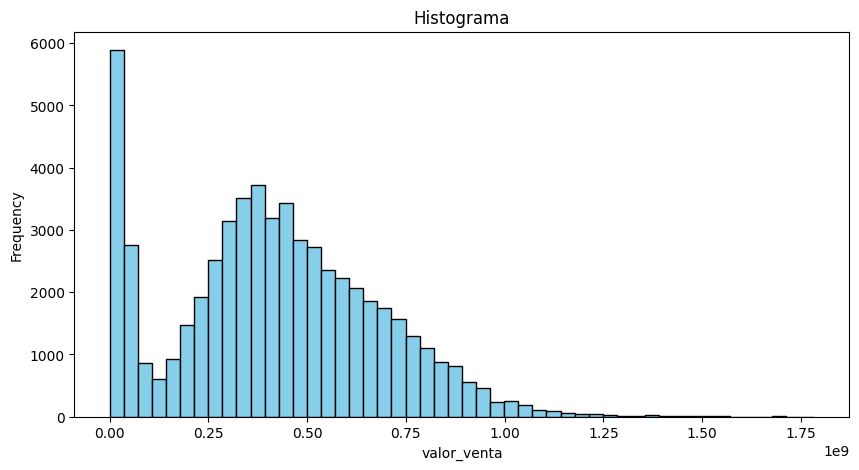

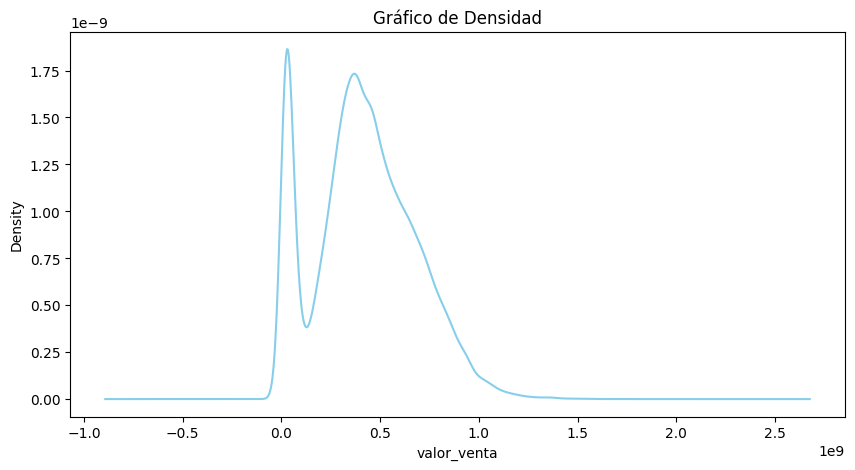

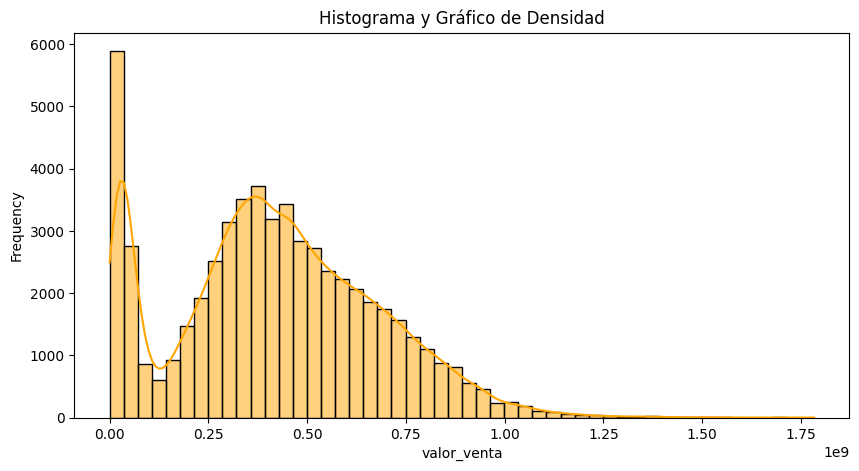

In [34]:
utils.univariate_analysis_continuos_variables(dataframe[[target]])

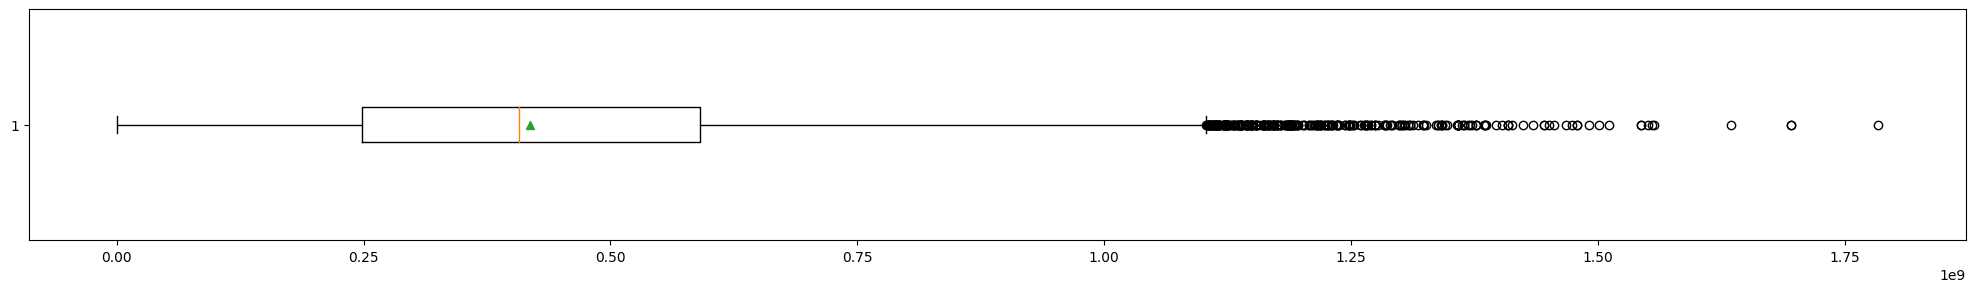

In [35]:
plt.figure(figsize=(25, 3))
plt.boxplot(df[target], showmeans=True, vert=False)
plt.show()

### **Correlación entre la variable target y los atributos numericos**

In [36]:
correlation_matrix = df.corr()

/tmp/ipykernel_425957/4214245630.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [37]:
correlation_matrix[target].sort_values(ascending=False)

valor_venta                    1.000000
Parte de valor_venta           0.901565
Hora entera                    0.359455
Año                            0.090050
Pasajeros saliendo             0.060858
Hdi2021                        0.036497
Pasajeros por Muelle y Hora    0.033316
Día                            0.028282
GdpPerCapitaUN                -0.001584
Porcentaje pasajeros vuelo    -0.014497
Mes                           -0.022972
Semana                        -0.025109
Minuto entero                 -0.072833
Name: valor_venta, dtype: float64

### **Correlación entre la variable target y los atributos de texto**

In [38]:
# text variables
text_features = ['Sala', 'Tipo aerolínea', 'Continente Destino']

### **Análisis de la varianza (ANOVA) para variables categóricas**

In [39]:
def remove_null_rows(df, target, text_features):
    # Filtrar las filas con valores nulos en las variables categóricas y en la variable objetivo
    filtered_df = df.dropna(subset=text_features + [target])

    return filtered_df

In [40]:
df_anova_test = remove_null_rows(dataframe, target, text_features)

In [41]:
# Realiza una prueba de ANOVA para cada variable categórica
for cat_var in text_features:
    groups = [group for name, group in df_anova_test.groupby(cat_var)[target]]
    f_statistic, p_value = f_oneway(*groups)

    if p_value < 0.05:  # Establece un umbral de significancia
        print(f"{cat_var} y {target} están correlacionados (p-value: {p_value})\n")
    else:
        print(f"{cat_var} y {target} NO están correlacionados (p-value: {p_value})\n")

Sala y valor_venta están correlacionados (p-value: 3.635032257561665e-154)

Tipo aerolínea y valor_venta están correlacionados (p-value: 2.281817224565551e-218)

Continente Destino y valor_venta están correlacionados (p-value: 1.1664143413848539e-154)



### **Matriz de correlación entre atributos**

/tmp/ipykernel_425957/192665668.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


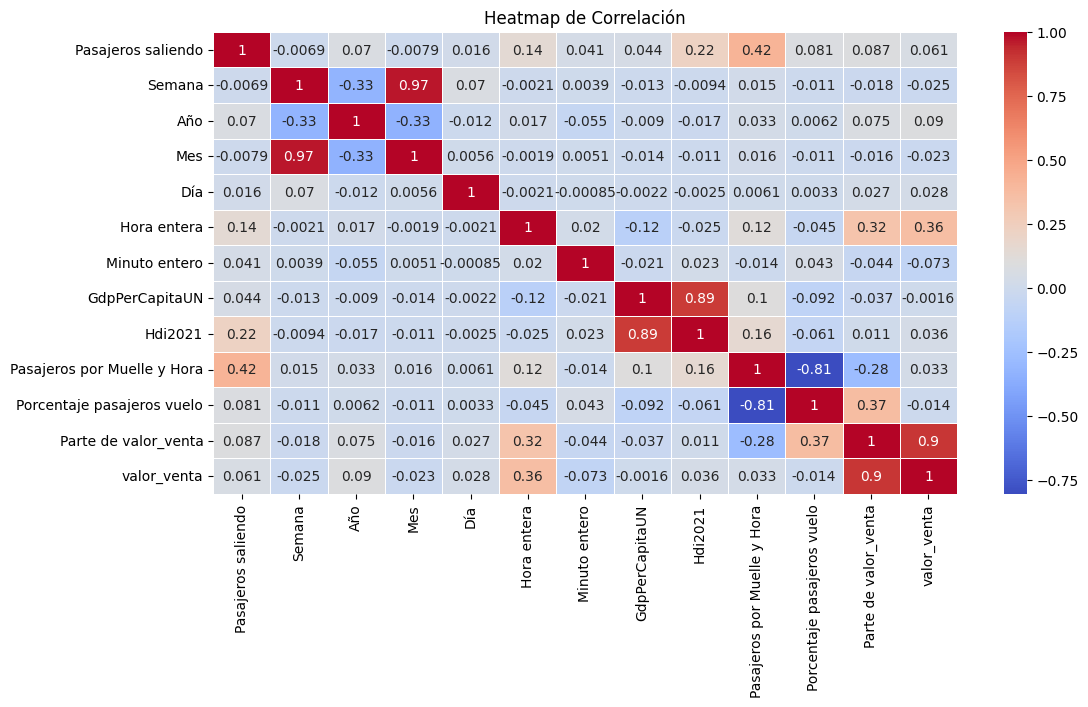

In [42]:
# Correlation matrix between features
correlation = df.corr()

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap de Correlación')

# Rotar los labels del eje y
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

### **Retiramos los atributos que presentan una alta correlación entre ellos o una no significativa**
Se determina que una correlacion es significativa con la variable objetivo si su valor absoluto esta encima de 0.2. 

In [43]:
features = ['Sala', 'Tipo aerolínea',  'Pasajeros saliendo', 'Año', 'Día', 'Hora entera', 'Continente Destino', 
            'Hdi2021', 'Pasajeros por Muelle y Hora']

In [44]:
df = df[features+[target]].copy()

In [45]:
df

,Sala,Tipo aerolínea,Pasajeros saliendo,Año,Día,Hora entera,Continente Destino,Hdi2021,Pasajeros por Muelle y Hora,valor_venta
0,a1,legacy,90.0,2022,9,22,South America,0.842,90.0,520032165.7
1,a1,legacy,74.0,2022,11,22,South America,0.842,74.0,607005040.2
2,a1,legacy,80.0,2022,21,22,South America,0.842,80.0,456810191.8
3,a1,legacy,118.0,2023,29,22,South America,0.842,118.0,597520364.9
4,a1,legacy,112.0,2023,6,0,South America,0.842,112.0,497686494.7
...,...,...,...,...,...,...,...,...,...,...
57472,a9b,legacy,93.0,2022,21,14,North America,0.936,93.0,656639977.6
57473,a9b,legacy,94.0,2022,26,14,North America,0.936,94.0,768444414.0
57474,a9b,legacy,97.0,2022,29,14,North America,0.936,97.0,847381148.7
57475,a9b,legacy,98.0,2022,11,15,North America,0.936,98.0,745755299.6


### **Matriz de correlación**

/tmp/ipykernel_425957/2947764158.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df[features].corr()


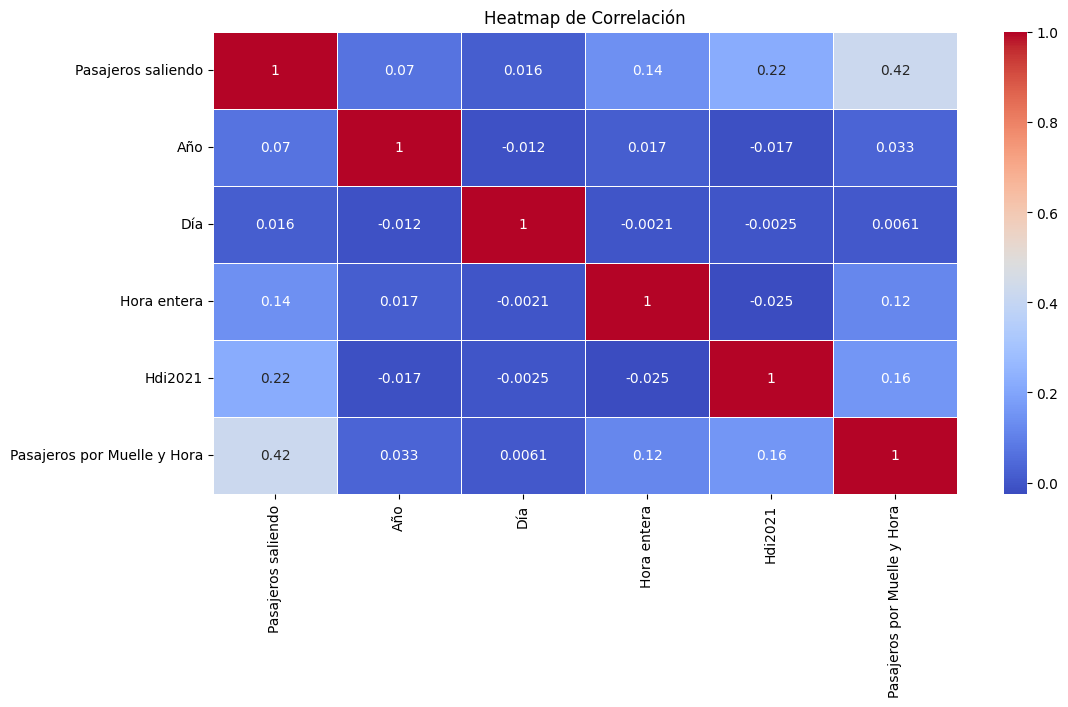

In [46]:
correlation = df[features].corr()

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap de Correlación')

heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

## **División de datos entrenamiento y test**

Primero, se construyen los conjuntos de entrenamiento y test que van a ser utilizados durante el desarrollo del modelo. Para este caso, se determina utilizar el 20% de los datos suministrados como datos de test.

In [47]:
X = df[features]
X.shape

(57477, 9)

In [48]:
Y = df[target]
Y.shape

(57477,)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [50]:
X_train.shape

(45981, 9)

In [51]:
X_test.shape

(11496, 9)

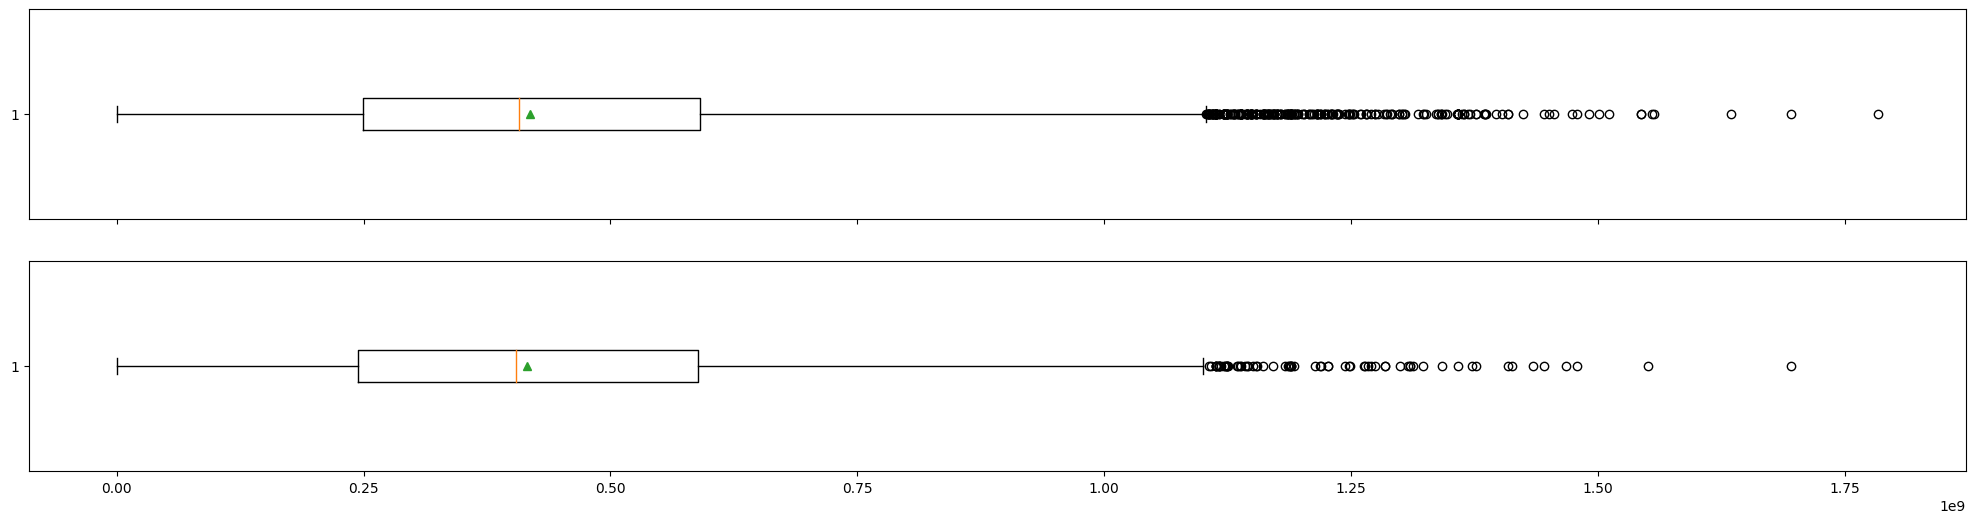

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 6))
ax1.boxplot(Y_train, showmeans=True, vert=False)
ax2.boxplot(Y_test, showmeans=True, vert=False)
plt.show()

## **Preparación de los datos**

a continuación se realiza una serie de pasos para preparar y transformar el conjunto de datos. El objetivo principal es preparar los datos para su uso en un modelo de aprendizaje automático. Aquí está una explicación paso a paso de lo que se está haciendo:

**1. Selección de Columnas:** Se comienza seleccionando las columnas del conjunto de datos que se utilizarán en el análisis. En este caso, se han definido dos tipos de columnas: columnas numéricas y categóricas. 

In [53]:
# Numeric columns
numeric_columns = ['Pasajeros saliendo', 'Año', 'Día', 'Hora entera', 'Hdi2021', 'Pasajeros por Muelle y Hora']

# Categorical column
categorical_columns = ['Sala', 'Tipo aerolínea', 'Continente Destino']

**2. Definición de Transformaciones para Columnas Numéricas:** Se definen las transformaciones que se aplicarán a las columnas numéricas. En este caso, se utilizan dos transformaciones: la primera es un "imputer" (SimpleImputer) que rellenará los valores faltantes en las columnas numéricas con la mediana de cada columna, se utilizara la mediana ya que en los resultados del análisis univariado identificamos una alta dispersión de los datos. La segunda transformación es un escalador (StandardScaler).

In [54]:
# Define transformations for numeric columns
numeric_transformations = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]

**3. Creación de un Codificador One-Hot:** Se crea un codificador "OneHotEncoder" que se utilizará para codificar las columnas categóricas. Este codificador se configura para manejar valores desconocidos ("handle_unknown='ignore'") y generar matrices densas en lugar de matrices dispersas ("sparse=False").

In [55]:
# Create a OneHotEncoder, but don't fit it yet
categorical_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

**4. Creación de un ColumnTransformer:** Se crea un transformador de columnas (ColumnTransformer) que aplicará las transformaciones definidas en el paso 2 a las columnas numéricas y utilizará el codificador One-Hot definido en el paso 3 para las columnas categóricas.

In [56]:
# Create a ColumnTransformer that applies the transformations to the corresponding columns.
preprocessing = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline(numeric_transformations), numeric_columns),
        ('categorical', categorical_encoder, categorical_columns)
    ])

**5. Creación del Pipeline:** Se crea un pipeline que encapsula todo el proceso de transformación. El pipeline se compone de un solo paso llamado "preprocessing" que aplica el transformador de columnas definido en el paso 4.

In [57]:
# Create the complete pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing)
])

**6. Ajuste del Pipeline a los Datos de Entrenamiento:** El pipeline se ajusta a los datos de entrenamiento (X_train) utilizando el método "fit". Esto significa que se calcularán los parámetros necesarios para aplicar las transformaciones a los datos.

In [58]:
# Fit the pipeline to the data
pipeline.fit(X_train)

/home/johan/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pasajeros saliendo', 'Año',
                                                   'Día', 'Hora entera',
                                                   'Hdi2021',
                                                   'Pasajeros por Muelle y '
                                                   'Hora']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sala', 'Tipo aerolínea',
                                                   'Continente Destino'])]))])

**7. Obtención de Nombres de Columnas Codificadas:** Se obtienen los nombres de las columnas después de aplicar la codificación One-Hot a la columna categórica. Esto se hace mediante la inspección de los pasos internos del pipeline y se obtienen los nombres utilizando el método "get_feature_names_out".

In [59]:
# Get the column names after encoding
encoded_column_names = list(pipeline.named_steps['preprocessing']
                             .named_transformers_['categorical']
                             .get_feature_names_out(input_features=categorical_columns))

**8. Combinación de Nombres de Columnas:** Se combinan los nombres de las columnas numéricas y las columnas codificadas en una lista llamada "all_column_names".

In [60]:
# Combine the names of numeric and encoded categorical columns
all_column_names = numeric_columns + encoded_column_names

**9. Aplicación del Pipeline a los Datos de Entrenamiento:** Se aplica el pipeline a los datos de entrenamiento (X_train) utilizando el método "transform". Esto realiza todas las transformaciones definidas anteriormente en los datos de entrenamiento.

In [61]:
# Apply the pipeline to the data
process_data = pipeline.transform(X_train)

**10. Creación de un DataFrame con los Datos Procesados:** Se crea un DataFrame llamado "X_train_clean" con los datos procesados y los nombres de las columnas definidos en el paso 8. Este DataFrame se utilizará para entrenar el modelo de regresión.

In [62]:
# Create a DataFrame with the processed data and column names
X_train_clean = pd.DataFrame(process_data, columns=all_column_names)

In [63]:
X_train_clean.head()

,Pasajeros saliendo,Año,Día,Hora entera,Hdi2021,Pasajeros por Muelle y Hora,Sala_a1,Sala_a10,Sala_a11,Sala_a12,Sala_a13,Sala_a14,Sala_a2,Sala_a3,Sala_a4,Sala_a5,Sala_a6,Sala_a7a,Sala_a7b,Sala_a7c,Sala_a8,Sala_a9a,Sala_a9b,Sala_en,Sala_rori,Tipo aerolínea_charter,Tipo aerolínea_legacy,Tipo aerolínea_low cost,Tipo aerolínea_regional,Continente Destino_Asia,Continente Destino_Europe,Continente Destino_North America,Continente Destino_South America
0,1.895623,1.156864,0.372434,-1.853965,0.966995,0.397276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.974530,-0.864406,0.599061,-0.198002,-0.268783,-0.818529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.257811,-0.864406,1.505566,-0.649628,1.193975,0.127097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.506040,-0.864406,-0.760697,1.457960,1.193975,-1.043678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.641260,-0.864406,1.505566,0.554708,1.446174,-0.134076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
X_train_clean.shape

(45981, 33)

In [65]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45981 entries, 0 to 45980
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pasajeros saliendo                45981 non-null  float64
 1   Año                               45981 non-null  float64
 2   Día                               45981 non-null  float64
 3   Hora entera                       45981 non-null  float64
 4   Hdi2021                           45981 non-null  float64
 5   Pasajeros por Muelle y Hora       45981 non-null  float64
 6   Sala_a1                           45981 non-null  float64
 7   Sala_a10                          45981 non-null  float64
 8   Sala_a11                          45981 non-null  float64
 9   Sala_a12                          45981 non-null  float64
 10  Sala_a13                          45981 non-null  float64
 11  Sala_a14                          45981 non-null  float64
 12  Sala

In [66]:
Y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 45981 entries, 3940 to 38408
Series name: valor_venta
Non-Null Count  Dtype  
--------------  -----  
45981 non-null  float64
dtypes: float64(1)
memory usage: 718.5 KB


## **2. Entrenamiento del modelo de regresión**

### **Primer modelo: Regresión lineal**

In [67]:
regression = LinearRegression()

In [68]:
regression.fit(X_train_clean, Y_train)

LinearRegression()

In [69]:
coefficients_df = pd.concat([
    pd.Series(all_column_names),
    pd.Series(regression.coef_)
], axis=1).rename(columns={0: "feature", 1: "value"})
coefficients_df

,feature,value
0,Pasajeros saliendo,2.220911e+07
1,Año,1.940925e+07
2,Día,7.270219e+06
3,Hora entera,9.234708e+07
4,Hdi2021,2.280727e+07
5,Pasajeros por Muelle y Hora,-1.032966e+07
6,Sala_a1,-1.198907e+07
7,Sala_a10,-4.538825e+07
8,Sala_a11,-1.935259e+07
9,Sala_a12,-1.856427e+07


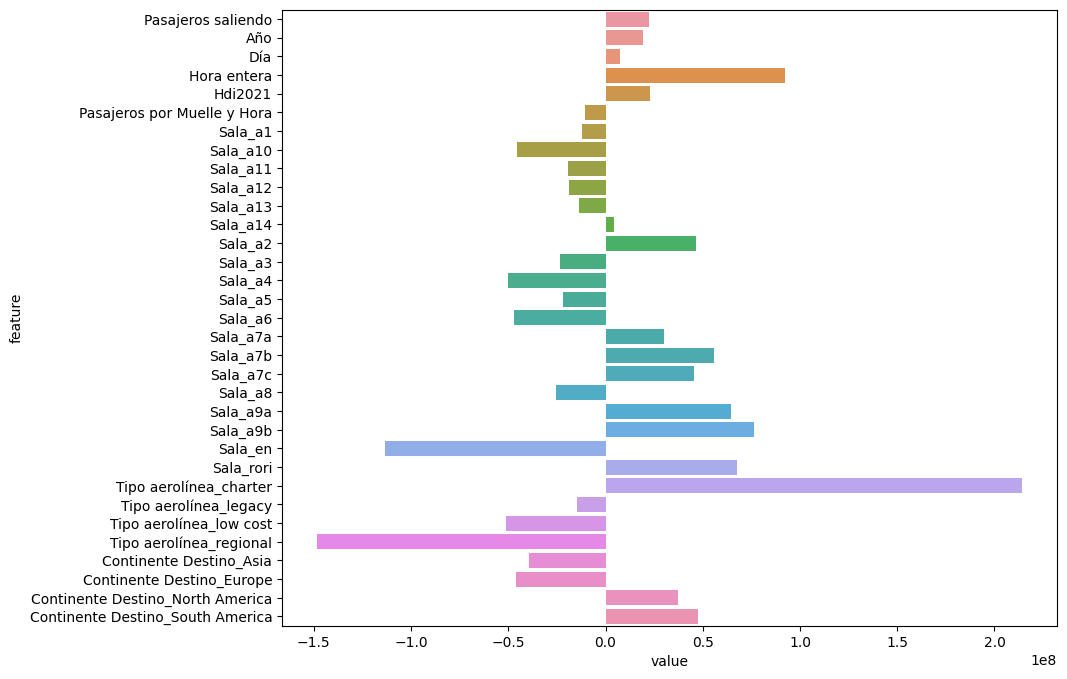

In [70]:
plt.figure(figsize=(10, 8))
sns.barplot(
    y=coefficients_df["feature"],
    x=coefficients_df["value"],
    orient="h"
)
plt.show()

In [71]:
regression.intercept_

422574537.5772504

### **Validación (evaluación) del modelo**

La forma más básica para saber que tan bien se comporta el modelo es midiendo que tanto se alejan las estimaciones o predicciones del mismo respecto a la variable objetivo real. Esta medición se puede hacer tanto para el conjunto de datos de entrenamiento como para el de prueba.

### **Transformación al conjunto test**

In [72]:
# Applies the same transformations to the test set
X_test_clean = pipeline.transform(X_test)

# Creates a DataFrame with the processed data and the column names
X_test_clean = pd.DataFrame(X_test_clean, columns=all_column_names)

In [73]:
X_test_clean.head()

,Pasajeros saliendo,Año,Día,Hora entera,Hdi2021,Pasajeros por Muelle y Hora,Sala_a1,Sala_a10,Sala_a11,Sala_a12,Sala_a13,Sala_a14,Sala_a2,Sala_a3,Sala_a4,Sala_a5,Sala_a6,Sala_a7a,Sala_a7b,Sala_a7c,Sala_a8,Sala_a9a,Sala_a9b,Sala_en,Sala_rori,Tipo aerolínea_charter,Tipo aerolínea_legacy,Tipo aerolínea_low cost,Tipo aerolínea_regional,Continente Destino_Asia,Continente Destino_Europe,Continente Destino_North America,Continente Destino_South America
0,-0.506802,1.156864,1.392253,0.103082,-0.268783,0.766520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.017812,1.156864,1.392253,-0.047460,-0.268783,-0.413261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.698145,-0.864406,-1.667202,1.608503,1.193975,-0.701451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.166635,-0.864406,0.825687,1.307418,0.197786,-0.476302,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.719406,-0.864406,-0.647384,0.103082,1.030045,-0.710457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
dataframe[target].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.85, 0.90, 0.95])

count    5.747700e+04
mean     4.180949e+08
std      2.573630e+08
min      0.000000e+00
5%       2.193772e+07
25%      2.486026e+08
50%      4.072462e+08
75%      5.904153e+08
85%      6.945800e+08
90%      7.592492e+08
95%      8.571160e+08
max      1.783547e+09
Name: valor_venta, dtype: float64

**Mean Absolute Error (MAE)**

In [75]:
train_mae_model_1 = mean_absolute_error(Y_train, regression.predict(X_train_clean))
test_mae_model_1 = mean_absolute_error(Y_test, regression.predict(X_test_clean))

print("Train MAE (Regression):", train_mae_model_1)
print("Test MAE (Regression):", test_mae_model_1)

Train MAE (Regression): 188729043.8796422
Test MAE (Regression): 188834287.29662097


**Root Mean Squeared Error (RMSE)**

In [76]:
train_rmse_model_1 = np.sqrt(mean_squared_error(Y_train, regression.predict(X_train_clean)))
test_rmse_model_1 = np.sqrt(mean_squared_error(Y_test, regression.predict(X_test_clean)))

print("Train RMSE (Regression):", train_rmse_model_1)
print("Test RMSE (Regression):", test_rmse_model_1)

Train RMSE (Regression): 235306444.52488968
Test RMSE (Regression): 236336171.97568858


**R² ajustado**

El coeficiente de determinación ajustado, conocido como R-cuadrado ajustado o R² ajustado, es una métrica que se utiliza para evaluar la calidad de un modelo de regresión. A diferencia del R-cuadrado común (R²), que simplemente indica la proporción de la varianza explicada por el modelo, el R² ajustado tiene en cuenta el número de predictores o características en el modelo. Ayuda a penalizar la inclusión de características irrelevantes o redundantes en el modelo.

In [77]:
# Calculate the R-squared of the model.
r2 = r2_score(Y_test, regression.predict(X_test_clean))

# Get the number of observations and predictor variables.
n = len(X_test_clean)
k = X_test_clean.shape[1]

# Calculates the adjusted R-squared
adjusted_r2_m1 = 1 - ((n - 1) / (n - k - 1)) * (1 - r2)

print("R² ajustado:", adjusted_r2_m1)

R² ajustado: 0.16234562343285364


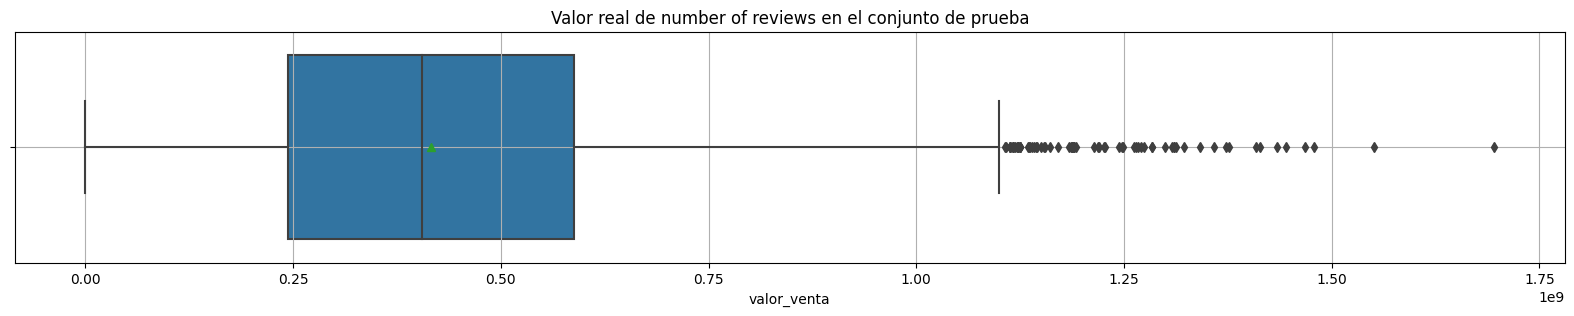

In [78]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=Y_test, showmeans=True, orient="h")
plt.title("Valor real de number of reviews en el conjunto de prueba")
plt.grid()
plt.show()

In [79]:
Y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    1.149600e+04
mean     4.158667e+08
std      2.586074e+08
min      0.000000e+00
25%      2.441407e+08
50%      4.046871e+08
75%      5.885711e+08
99%      1.043165e+09
max      1.695835e+09
Name: valor_venta, dtype: float64

### **Validación de supuestos**

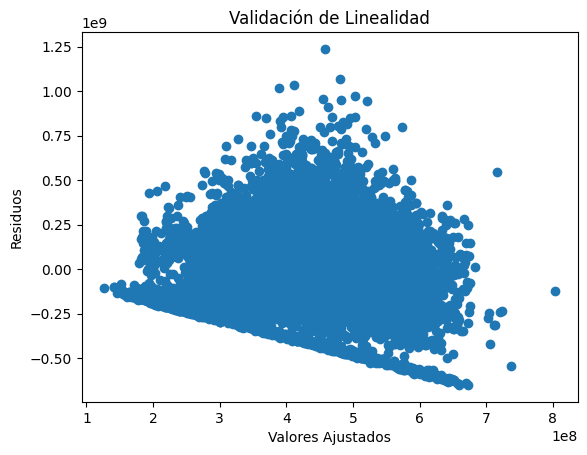

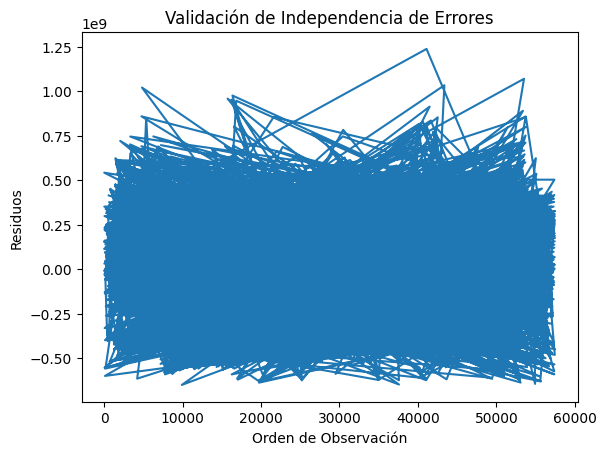

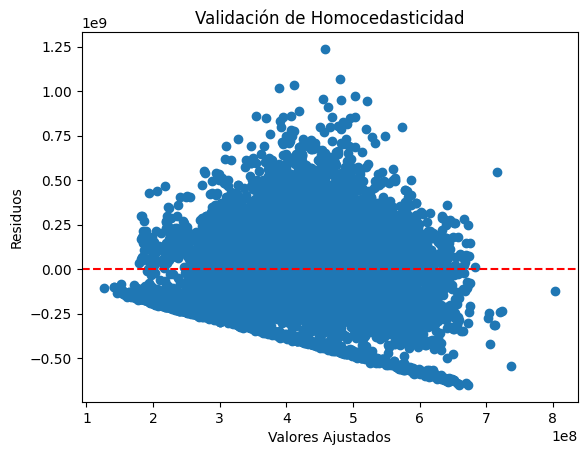

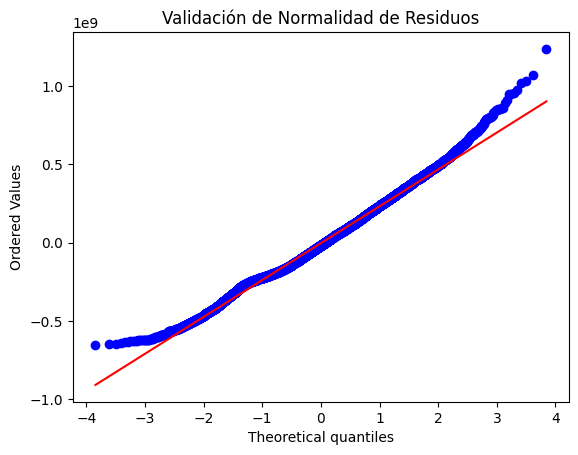

In [80]:
# Get predictions
y_pred = regression.predict(X_test_clean)

# get the residuals
residuos = Y_test - y_pred

# 1. Linealidad
# Gráfico de dispersión de residuos vs. valores ajustados
plt.scatter(y_pred, residuos)
plt.xlabel("Valores Ajustados")
plt.ylabel("Residuos")
plt.title("Validación de Linealidad")
plt.show()

# 2. Independencia de Errores
# Gráfico de residuos vs. orden de observación
plt.plot(residuos)
plt.xlabel("Orden de Observación")
plt.ylabel("Residuos")
plt.title("Validación de Independencia de Errores")
plt.show()

# 3. Homocedasticidad
# Gráfico de residuos vs. valores ajustados
plt.scatter(y_pred, residuos)
plt.xlabel("Valores Ajustados")
plt.ylabel("Residuos")
plt.title("Validación de Homocedasticidad")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 4. Normalidad de Residuos
# Gráfico de probabilidad normal (Q-Q plot)
stats.probplot(residuos, plot=plt)
plt.title("Validación de Normalidad de Residuos")
plt.show()

### **Analisis de relevancia con OLS**

In [81]:
X2 = sm.add_constant(X_train_clean)
est = sm.OLS(Y_train.reset_index(drop=True), X2)
est2 = est.fit()
summary_ols = est2.summary()

In [82]:
print(summary_ols)

                            OLS Regression Results                            
Dep. Variable:            valor_venta   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     296.1
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:26:55   Log-Likelihood:            -9.5159e+05
No. Observations:               45981   AIC:                         1.903e+06
Df Residuals:                   45950   BIC:                         1.904e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [83]:
with open("data/ols_report.txt", "w") as f:
    f.write(summary_ols.as_text())